In [1]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

from lib.dataset.parse_heightmap import parse_heightmap
from lib.ai.model_rainfallwater_mono import model_rainfallwater_mono
from lib.ai.helpers.make_callbacks import make_callbacks
from lib.ai.helpers.summarywriter import summarywriter

2023-01-06 18:45:38.088928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 18:45:38.088955: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
filepath_heightmap="/mnt/research-data/main/terrain50-nimrodsized.json.gz"

dir_output = "/tmp/x/mono_segment_TEST"
if not os.path.exists(os.path.join(dir_output, "checkpoints")):
	os.makedirs(os.path.join(dir_output, "checkpoints"))

In [3]:
model = model_rainfallwater_mono(
	metadata={ "rainfallradar": [ 1, 64, 64 ] },
	model_arch_dec="convnext_i_xxtiny",
	learning_rate=3e-5
)

summarywriter(model, filepath_output=os.path.join(dir_output, "summary.txt"))

RAINFALL channels 1 width 64 height 64 HEIGHTMAP_INPUT False
convnext:shape IN x (None, 64, 64, 1)


2023-01-06 18:45:42.019487: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 18:45:42.019743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-06 18:45:42.019824: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-01-06 18:45:42.019903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-01-06 18:45:42.019979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

DEBUG:model ENCODER output_shape (None, 512)
DEBUG:model BOTTLENECK:stack2image output_shape (None, 4, 4, 512)


2023-01-06 18:45:44.801 | WARNING  | lib.ai.model_rainfallwater_mono:model_rainfallwater_mono:71 - Warning: TODO implement attention from https://ieeexplore.ieee.org/document/9076883
2023-01-06 18:45:44.833 | INFO     | lib.ai.model_rainfallwater_mono:model_rainfallwater_mono:86 - learning_rate: 3e-05


cells 4096 cells/2 2048.0 shape+ (64, 64) tf.Tensor(1015, shape=(), dtype=int64)


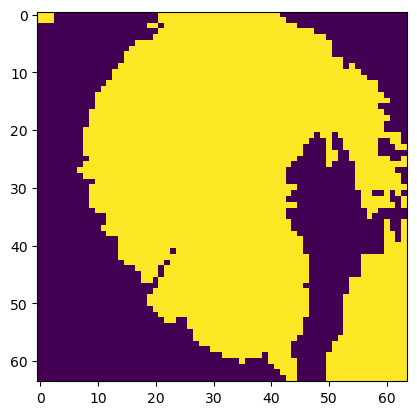

In [5]:
heightmap = parse_heightmap(filepath_heightmap) / 100
heightmap = tf.image.crop_to_bounding_box(tf.expand_dims(heightmap, axis=-1), 0, 0, 64, 64)
#heightmap_labels = tf.one_hot(tf.cast(tf.math.greater(tf.squeeze(heightmap)/10, 0.05), dtype=tf.int32), 2)
heightmap_labels = tf.cast(tf.math.greater(tf.squeeze(heightmap)/10, 0.05), dtype=tf.int32)

dataset = tf.data.Dataset.from_tensor_slices([heightmap_labels]).map(
	lambda tensor: tf.expand_dims(tensor, axis=-1),
	num_parallel_calls=tf.data.AUTOTUNE
)
dataset_labels = tf.data.Dataset.from_tensor_slices([heightmap_labels])

for item in dataset_labels:
	print("cells", 64*64, "cells/2", (64*64)/2, "shape+", item.shape, tf.math.reduce_sum(tf.math.argmax(item, axis=-1)))
	break
dataset = tf.data.Dataset.zip((dataset, dataset_labels)) \
	.repeat(64 * 64) \
	.batch(64) \
	.prefetch(tf.data.AUTOTUNE)


plt.imshow(tf.squeeze(heightmap_labels))

In [5]:
model.fit(
	dataset,
	epochs=25,
	callbacks=make_callbacks("/tmp/x/mono_segment_TEST", model)
)

Epoch 1/25
64/64 [==============================] - ETA: 0s - loss: 0.0863 - binary_accuracy: 0.5702

2023-01-05 20:13:58.692 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 20:13:59.282 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 552s 8s/step - loss: 0.0863 - binary_accuracy: 0.5702
Epoch 2/25
64/64 [==============================] - ETA: 0s - loss: -0.1695 - binary_accuracy: 0.5977

2023-01-05 20:22:53.006 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 20:22:53.575 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.1695 - binary_accuracy: 0.5977
Epoch 3/25
64/64 [==============================] - ETA: 0s - loss: -0.1154 - binary_accuracy: 0.5065

2023-01-05 20:31:46.951 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 20:31:47.518 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.1154 - binary_accuracy: 0.5065
Epoch 4/25
64/64 [==============================] - ETA: 0s - loss: -0.2798 - binary_accuracy: 0.4606

2023-01-05 20:40:40.765 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 20:40:41.338 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.2798 - binary_accuracy: 0.4606
Epoch 5/25
64/64 [==============================] - ETA: 0s - loss: -0.0833 - binary_accuracy: 0.4692

2023-01-05 20:49:34.870 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 20:49:35.429 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.0833 - binary_accuracy: 0.4692
Epoch 6/25
64/64 [==============================] - ETA: 0s - loss: 0.0793 - binary_accuracy: 0.5488

2023-01-05 20:58:26.682 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 20:58:27.245 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 532s 8s/step - loss: 0.0793 - binary_accuracy: 0.5488
Epoch 7/25
64/64 [==============================] - ETA: 0s - loss: 0.0547 - binary_accuracy: 0.5568

2023-01-05 21:07:17.933 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 21:07:18.495 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 531s 8s/step - loss: 0.0547 - binary_accuracy: 0.5568
Epoch 8/25
64/64 [==============================] - ETA: 0s - loss: 0.0304 - binary_accuracy: 0.5615

2023-01-05 21:16:09.952 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 21:16:10.519 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 532s 8s/step - loss: 0.0304 - binary_accuracy: 0.5615
Epoch 9/25
64/64 [==============================] - ETA: 0s - loss: 0.0066 - binary_accuracy: 0.5657

2023-01-05 21:25:03.040 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 21:25:03.614 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 533s 8s/step - loss: 0.0066 - binary_accuracy: 0.5657
Epoch 10/25
64/64 [==============================] - ETA: 0s - loss: -0.0154 - binary_accuracy: 0.5707

2023-01-05 21:33:57.583 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 21:33:58.155 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.0154 - binary_accuracy: 0.5707
Epoch 11/25
64/64 [==============================] - ETA: 0s - loss: -0.0363 - binary_accuracy: 0.5749

2023-01-05 21:42:52.326 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 21:42:52.898 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.0363 - binary_accuracy: 0.5749
Epoch 12/25
64/64 [==============================] - ETA: 0s - loss: -0.0575 - binary_accuracy: 0.5775

2023-01-05 21:51:46.051 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 21:51:46.627 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.0575 - binary_accuracy: 0.5775
Epoch 13/25
64/64 [==============================] - ETA: 0s - loss: -0.0828 - binary_accuracy: 0.5835

2023-01-05 22:00:40.405 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:00:40.971 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.0828 - binary_accuracy: 0.5835
Epoch 14/25
64/64 [==============================] - ETA: 0s - loss: -0.1216 - binary_accuracy: 0.5869

2023-01-05 22:09:34.844 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:09:35.418 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.1216 - binary_accuracy: 0.5869
Epoch 15/25
64/64 [==============================] - ETA: 0s - loss: -0.1928 - binary_accuracy: 0.5821

2023-01-05 22:18:28.651 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:18:29.219 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.1928 - binary_accuracy: 0.5821
Epoch 16/25
64/64 [==============================] - ETA: 0s - loss: -0.2815 - binary_accuracy: 0.5564

2023-01-05 22:27:23.336 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:27:23.906 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.2815 - binary_accuracy: 0.5564
Epoch 17/25
64/64 [==============================] - ETA: 0s - loss: -0.2078 - binary_accuracy: 0.4880

2023-01-05 22:36:18.191 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:36:18.761 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.2078 - binary_accuracy: 0.4880
Epoch 18/25
64/64 [==============================] - ETA: 0s - loss: -0.2591 - binary_accuracy: 0.4643

2023-01-05 22:45:13.175 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:45:13.744 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.2591 - binary_accuracy: 0.4643
Epoch 19/25
64/64 [==============================] - ETA: 0s - loss: -0.4663 - binary_accuracy: 0.4370

2023-01-05 22:54:08.037 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 22:54:08.624 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.4663 - binary_accuracy: 0.4370
Epoch 20/25
64/64 [==============================] - ETA: 0s - loss: 0.0233 - binary_accuracy: 0.5323

2023-01-05 23:03:03.088 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 23:03:03.655 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: 0.0233 - binary_accuracy: 0.5323
Epoch 21/25
64/64 [==============================] - ETA: 0s - loss: 0.0272 - binary_accuracy: 0.5650

2023-01-05 23:11:57.541 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 23:11:58.301 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: 0.0272 - binary_accuracy: 0.5650
Epoch 22/25
64/64 [==============================] - ETA: 0s - loss: 0.0047 - binary_accuracy: 0.5712

2023-01-05 23:20:52.402 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 23:20:52.969 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: 0.0047 - binary_accuracy: 0.5712
Epoch 23/25
64/64 [==============================] - ETA: 0s - loss: -0.0151 - binary_accuracy: 0.5776

2023-01-05 23:29:46.982 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 23:29:47.558 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 535s 8s/step - loss: -0.0151 - binary_accuracy: 0.5776
Epoch 24/25
64/64 [==============================] - ETA: 0s - loss: -0.0319 - binary_accuracy: 0.5800

2023-01-05 23:38:40.377 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 23:38:40.948 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 533s 8s/step - loss: -0.0319 - binary_accuracy: 0.5800
Epoch 25/25
64/64 [==============================] - ETA: 0s - loss: -0.0465 - binary_accuracy: 0.5806

2023-01-05 23:47:34.752 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:12 - Saving checkpoint
2023-01-05 23:47:35.313 | INFO     | lib.ai.components.CallbackCustomModelCheckpoint:on_epoch_end:15 - Checkpoint saved successfully


64/64 [==============================] - 534s 8s/step - loss: -0.0465 - binary_accuracy: 0.5806


1/1 [==============================] - 2s 2s/step
tf.Tensor(
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [0 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]], shape=(1, 64, 64), dtype=int32)
tf.Tensor(3936, shape=(), dtype=int32) tf.Tensor(160, shape=(), dtype=int32)
(1, 64, 64)
[[[ 6.318168    4.484145    5.098278   ...  2.2153077   4.2120304
    3.6126046 ]
  [ 6.4958954   5.6199083   6.5477724  ...  1.4242218   3.6372695
    4.750148  ]
  [ 4.059501    3.8315465   7.3975286  ...  5.0964937   4.767578
    2.0836473 ]
  ...
  [-0.3680715   1.0862777   4.403977   ...  3.2975245   3.878313
    1.355243  ]
  [ 7.1270704   3.7269826   4.1089396  ...  5.3976045   2.4421794
    2.3658426 ]
  [ 6.693168    7.6807394   5.613674   ...  0.89391357  3.4751601
    3.142672  ]]]


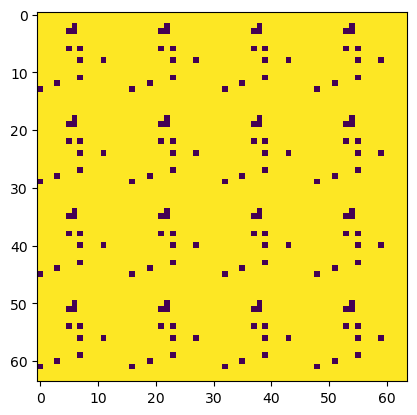

In [6]:
prediction = model.predict(tf.expand_dims(heightmap, axis=0))
prediction_binarised = tf.cast(tf.math.greater(prediction, 0.5), dtype=tf.int32)
print(prediction_binarised)
print(tf.math.reduce_sum(prediction_binarised), (64*64) - tf.math.reduce_sum(prediction_binarised))
print(prediction_binarised.shape)
print(prediction)
plt.imshow(tf.squeeze(prediction_binarised))